# Get bandpower errors from ILC residuals.

### Weights and residuals are provided for MV, tSZ-free, and CIB-free CMB/kSZ ILC maps.

#### File locaiton: publish/data/ilc_weights_residuals.npy

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import numpy as np, sys, os, scipy as sc, warnings
sys.path.append('modules')
import tools
import matplotlib.cbook
import scipy.ndimage as ndimage
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

#%pylab notebook
%matplotlib inline
from pylab import *


In [3]:
rcParams['figure.dpi'] = 150
rcParams['figure.facecolor'] = 'white'


In [4]:
#read file
which_fg_model = 'agora'

fname = 'publish/ilc/ilc_weights_residuals_%s_fg_model.npy' %(which_fg_model)
ilc_dict = np.load(fname, allow_pickle = True).item()
print(ilc_dict.keys())

#different types of ILC considered
ilc_keyname_arr = ilc_dict['ilc_keyname_arr']
print(ilc_keyname_arr)

#ILC weights
weights_dict = ilc_dict['weights']
print(weights_dict.keys())

#total ILC residuals
total_ilc_residuals_dict = ilc_dict['total_ilc_residuals']
print(total_ilc_residuals_dict.keys())

#CIB, tSZ, and CIB+tSZ
cib_ilc_residuals_dict = ilc_dict['cib_residuals']
tsz_ilc_residuals_dict = ilc_dict['tsz_residuals']
cib_plus_tsz_ilc_residuals_dict = ilc_dict['cib_plus_tsz_residuals']
radio_ilc_residuals_dict = ilc_dict['radio_residuals']
noise_ilc_residuals_dict = ilc_dict['noise_residuals']
print(cib_ilc_residuals_dict['s4_wide'].keys())

if (1): #with CCAT-prime
    #fname_withccatp = 'publish/data/ilc_weights_residuals_%s_fg_model_withccatp.npy' %(which_fg_model)
    fname_withccatp = 'publish/data/versions/20230327/ilc_weights_residuals_agora_fg_model_withccatphfnoisescaledby5.0.npy'
    ilc_dict_withccatp = np.load(fname_withccatp, allow_pickle = True).item()
    cib_plus_tsz_ilc_residuals_dict_withccatp = ilc_dict_withccatp['cib_plus_tsz_residuals']
    print(ilc_dict_withccatp.keys())


#el range
els = ilc_dict['el']

#smooth
perform_smoothing = True #just make the residuals smoother
if perform_smoothing:
    delta_el = 1
else:
    delta_el = 10

dict_keys(['weights', 'total_ilc_residuals', 'cib_plus_tsz_residuals', 'cib_residuals', 'tsz_residuals', 'noise_residuals', 'radio_residuals', 'nl_TP_dict', 'cl_signal_plus_noise', 'ilc_keyname_arr', 'el'])
['mv' 'tszfree' 'cibfree' 'mvxcibfree' 'mvxtszfree' 'tszfreexcibfree']
dict_keys(['s4_wide', 's4_deep', 'spt3g', 'spt4', 'so_baseline', 'so_goal'])
dict_keys(['s4_wide', 's4_deep', 'spt3g', 'spt4', 'so_baseline', 'so_goal'])
dict_keys(['mv', 'tszfree', 'cibfree', 'mvxcibfree', 'mvxtszfree', 'tszfreexcibfree'])
dict_keys(['weights', 'total_ilc_residuals', 'cib_plus_tsz_residuals', 'cib_residuals', 'tsz_residuals', 'nl_TP_dict', 'cl_signal_plus_noise', 'ilc_keyname_arr', 'el'])


In [5]:
#experiment names and colours
def get_colours(no_of_colors_reqd, cmap = cm.RdYlBu):    
    colorarr = [cmap(int(d)) for d in np.linspace(0, 255, no_of_colors_reqd)]
    if cmap == cm.RdYlBu:
        colorarr[2] = 'goldenrod'
    return colorarr

exp_specs_dict = {'s4_wide': ['S4-Wide', 'black'], 
                  's4_deep': ['S4-Ultra Deep', 'darkred'], 
                  'spt3g': ['SPT-3G', 'darkgreen'],
                  'spt4': ['SPT-3G w/ SPT-3G+', 'goldenrod'],
                  'so_baseline': ['SO-Baseline', 'royalblue'],
                  'so_goal': ['SO-Goal', 'darkorange']}

exp_specs_dict = {
                  's4_wide': ['S4-Wide', 0.5, 'black'], 
                  's4_deep': ['S4-Ultra Deep', 0.03, 'darkred'], 
                  'spt3g': ['SPT-3G', 0.03, 'darkgreen'],
                  'spt4': ['SPT-3G w/ SPT-4', 0.03, 'goldenrod'],
                  'so_baseline': ['SO-Baseline', 0.4, 'royalblue'],
                  'so_baseline_withccatp': ['SO-Baseline w/  FYST', 0.4, 'blue'], 
                  'so_goal': ['SO-Goal', 0.4, 'darkorange'],
                  'so_goal_withccatp': ['SO-Goal w/  FYST', 0.4, 'red'], 
                  }


'''
colorarr = get_colours( len(exp_specs_dict) )
for cntr, expname in enumerate( exp_specs_dict ):
    exp_specs_dict[expname][1] = colorarr[cntr]
'''

#experiment ordering
exparr = ['spt3g', 'spt4', 'so_baseline', 'so_goal', 's4_wide', 's4_deep']

#ILC keynames
ilc_keyname_dict = {'mv':'MV', 'tszfree': 'tSZ-free', 'cibfree': 'CIB-free'}

#CMB spectrum
camb_fname = 'publish/data/cmb_cl_planck_2015_lensedCls.dat'
el_camb = np.loadtxt(camb_fname, usecols = [0])
dl_camb = np.loadtxt(camb_fname, usecols = [1,2,3,4])
Tcmb = 2.73 #Kelvin
cl_camb = ( Tcmb**2. * dl_camb * 2 * np.pi ) / ( el_camb[:,None] * (el_camb[:,None] + 1) )
cl_camb *= 1e12
cl_TT, cl_EE, cl_BB, cl_TE = cl_camb.T

dl_fac_camb = el_camb * (el_camb+1)/2/np.pi


In [6]:
def fn_format_axis(ax,fx,fy):
    for label in ax.get_xticklabels(): label.set_fontsize(fx)
    for label in ax.get_yticklabels(): label.set_fontsize(fy)
    if (0):
        import matplotlib.ticker as ticker
        ax.xaxis.set_major_locator(ticker.MaxNLocator(4))
        ax.xaxis.set_minor_locator(ticker.MaNLocator(4))
        ax.yaxis.set_major_locator(ticker.MaNLocator(4))
        ax.yaxis.set_minor_locator(ticker.MaNLocator(4))
    return ax

[0.07081934533247243, 0.0512795129550904, 0.039882011031116556, 0.03403574579616437, 0.031332976311670056, 0.02965826934578823, 0.02937565746174567, 0.02891996338394621, 0.029443498719028183]
[0.08870381902435234, 0.07027047296783091, 0.060190248170619076, 0.056344293092369026, 0.05515248594831979, 0.055759879557344516, 0.058737645867639174, 0.061130480466392065, 0.06559446527946478]
[0.08948069585585097, 0.07440579011555251, 0.0673296737224642, 0.0660789349031614, 0.06841402023986004, 0.07178541920181843, 0.07708690776434839, 0.0807101616433862, 0.08894345663045686]
[0.16972415196349616, 0.15617906904753917, 0.1504150642222013, 0.15203744972806854, 0.1632246467856348, 0.17419575237166582, 0.18713266792350922, 0.19539565107378404, 0.21767853262494605]


<Figure size 900x600 with 0 Axes>

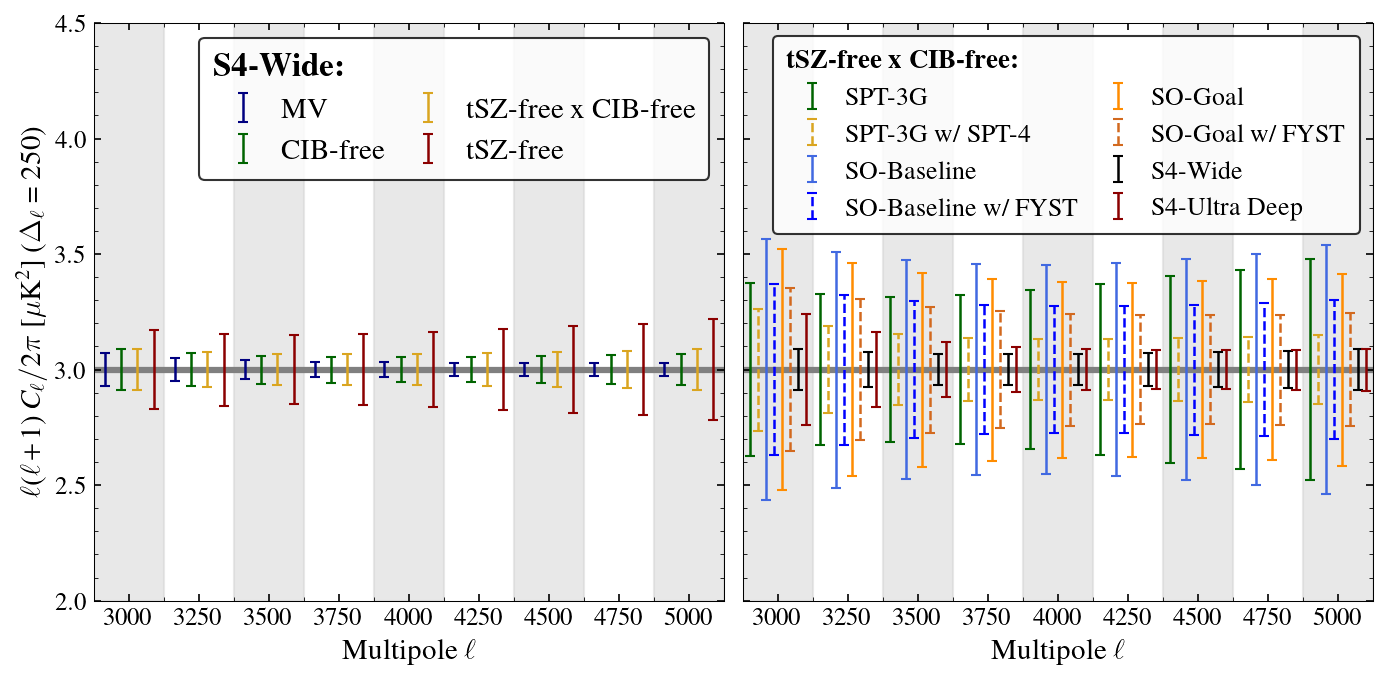

SystemExit: 

In [17]:
exp_specs_dict = {
                  's4_wide': ['S4-Wide', 0.5, 'black'], 
                  's4_deep': ['S4-Ultra Deep', 0.03, 'darkred'], 
                  'spt3g': ['SPT-3G', 0.03, 'darkgreen'],
                  'spt4': ['SPT-3G w/ SPT-4', 0.03, 'goldenrod'],
                  'so_baseline': ['SO-Baseline', 0.4, 'royalblue'],
                  'so_baseline_withccatp': ['SO-Baseline w/  FYST', 0.4, 'blue'], 
                  'so_goal': ['SO-Goal', 0.4, 'darkorange'],
                  'so_goal_withccatp': ['SO-Goal w/  FYST', 0.4, 'chocolate'], 
                  }

#get temperature ILC residuals
import copy
import matplotlib.ticker
delta_el = 250#0#0
fsval = 14
#xmin, xmax = 2350., 5150.
xmin, xmax = 3000.-delta_el/2, 5000.+delta_el/2
#xmin, xmax = 3000., 5000.
if delta_el == 1:
    ymin, ymax = -20., 20.
else:
    ymin, ymax = 2., 4.5
clf()
fig = figure(figsize=(11., 5.1))
subplots_adjust(wspace = 0.03)
tr, tc = 1, 2
for pl_iter in range(2):
    if pl_iter == 0:
        reqd_expname_arr = ['s4_wide']
        reqd_ilc_keyname_dict = {'mv': ['MV', 'navy'], 
                                 'cibfree': ['CIB-free', 'darkgreen'], 
                                 'tszfreexcibfree': ['tSZ-free x CIB-free', 'goldenrod'],
                                 'tszfree': ['tSZ-free', 'darkred'], 
                                 }
        xshift_arr = np.linspace(-delta_el*0.7/2, delta_el*0.7/2, len(reqd_ilc_keyname_dict))
    else:
        reqd_expname_arr = ['spt3g', 'spt4', 'so_baseline', 'so_baseline_withccatp', 
                            'so_goal', 'so_goal_withccatp', 
                            's4_wide', 's4_deep']
        #reqd_expname_arr = ['spt3g', 'so_goal', 's4_wide']
        xshift_arr = np.linspace(-delta_el*0.8/2, delta_el*0.8/2, len(reqd_expname_arr))
        
        reqd_ilc_keyname_dict = {'tszfreexcibfree': ['tSZ-free x CIB-free', 'goldenrod'],}
        #reqd_ilc_keyname_dict = {'tszfree': ['tSZ-free', 'darkred'], }
        #reqd_ilc_keyname_dict = {'mv': ['MV', 'navy']}
        
    ax = subplot(tr, tc, pl_iter + 1)
    #axhline(3., lw = 1., color = 'black')
    for reqd_expname_cntr, reqd_expname in enumerate( reqd_expname_arr ):
        expname_str, fsky, colorval = exp_specs_dict[reqd_expname]
        ##fsky = 0.002
        for reqd_ilc_keyname_cntr, reqd_ilc_keyname in enumerate( reqd_ilc_keyname_dict ):
            if reqd_ilc_keyname.find('x')>-1:
                reqd_ilc_keyname_1, reqd_ilc_keyname_2 = reqd_ilc_keyname.split('x')
            else:
                reqd_ilc_keyname_1 = reqd_ilc_keyname_2 = reqd_ilc_keyname
            els, total_ilc_residual_mv, total_ilc_residual_1, total_ilc_residual_2, total_ilc_residual_12 = tools.get_temperature_ilc_residuals(reqd_expname, reqd_ilc_keyname_1, reqd_ilc_keyname_2, quiet = True)
            if reqd_ilc_keyname_cntr == 0:
                cl_cmb_dict, cl_cmb_deriv_dict = tools.get_cmb_spectra(els, quiet = True)
                binned_el = np.arange(0., max(els), delta_el)
                dl_fac = els * (els+1)/2/np.pi    
                dl_ksz = np.tile( 3., len(els) )
                cl_ksz = dl_ksz / dl_fac
                cl_ksz[np.isinf(cl_ksz)] = 0.
            bands = tools.get_exp_bands(reqd_expname)

            #get MV polarisation ILC residuals
            els, mvilc_pol_residuals = tools.get_polarisation_mvilc_residuals(els, reqd_expname)

            cl_dic_forthisexp = copy.deepcopy(cl_cmb_dict)
            cl_dic_forthisexp['TT'] += cl_ksz #add kSZ signal
            cl_deriv_dic_forthisexp = copy.deepcopy(cl_cmb_deriv_dict)

            '''
            if (0):
                #get experiment-dependent radio stuffs
                cl_radio, cl_dic_forthisexp, cl_deriv_dic_forthisexp = tools.get_radio_spectrum_and_derivatives(els, reqd_expname, cl_dic_forthisexp, cl_deriv_dic_forthisexp, reqd_ilc_keyname_1, reqd_ilc_keyname_2 = reqd_ilc_keyname_2)

                #get experiment-dependent CIB+tSZ stuffs
                cl_cib_tsz, cl_dic_forthisexp, cl_deriv_dic_forthisexp = tools.get_cib_tsz_spectrum_and_derivatives(els, reqd_expname, cl_dic_forthisexp, cl_deriv_dic_forthisexp, 
                                                                                                              reqd_ilc_keyname_1, reqd_ilc_keyname_2 = reqd_ilc_keyname_2)

                total_ilc_residual_1 = total_ilc_residual_1 - cl_radio - cl_cib_tsz
                total_ilc_residual_2 = total_ilc_residual_2 - cl_radio - cl_cib_tsz
                total_ilc_residual_12 = total_ilc_residual_12 - cl_radio - cl_cib_tsz
            '''
                
            if (1):
                for which_spec in cl_dic_forthisexp:
                    cl_dic_forthisexp[which_spec] = np.interp(binned_el, els, cl_dic_forthisexp[which_spec])
                    
                total_ilc_residual_1 = np.interp(binned_el, els, total_ilc_residual_1)
                total_ilc_residual_2 = np.interp(binned_el, els, total_ilc_residual_2)
                total_ilc_residual_12 = np.interp(binned_el, els, total_ilc_residual_12)
                total_ilc_residual_mv = np.interp(binned_el, els, total_ilc_residual_mv)
                mvilc_pol_residuals = np.interp(binned_el, els, mvilc_pol_residuals)                
                els = np.copy(binned_el)
                
            #expname_str, colorval = exp_specs_dict[reqd_expname]
            delta_cl_dic, delta_cl_dic_mv = tools.wrapper_get_delta_cl(els, cl_dic_forthisexp, fsky, 
                                    total_ilc_residual_1, total_ilc_residual_2, total_ilc_residual_12, 
                                    total_ilc_residual_mv, mvilc_pol_residuals,
                                   )
            
            if (1): #perform binning
                curr_delta_cl = delta_cl_dic['TT']
                curr_delta_cl = np.interp(binned_el, els, curr_delta_cl)
                els = np.copy(binned_el)
                dl_fac = els * (els+1)/2/np.pi
                dl_ksz = np.tile( 3., len(els) )

            if pl_iter == 0:
                labval, colorval = reqd_ilc_keyname_dict[reqd_ilc_keyname]
                elshiftval = xshift_arr[reqd_ilc_keyname_cntr]
            else:
                labval, fsky, colorval = exp_specs_dict[reqd_expname]
                elshiftval = xshift_arr[reqd_expname_cntr]
            elinds_to_plot = np.where((els>=xmin) & (els<=xmax))
            eb = errorbar(els[elinds_to_plot] + elshiftval, dl_ksz[elinds_to_plot], yerr = dl_fac[elinds_to_plot] * curr_delta_cl[elinds_to_plot], marker = None, ls = 'None', color = colorval, label = labval, ecolor = colorval, capsize = 2.5, elinewidth = 1.2)
            if reqd_expname in ['spt4', 'so_baseline_withccatp', 'so_goal_withccatp']:
                eb[-1][0].set_linestyle('--')
            #errorbar(els, dl_ksz, yerr = dl_fac * curr_delta_cl, marker = None, ls = 'None', label = labval, ecolor = colorval)#, capsize = 2.5, elinewidth = 1.)
            
            if pl_iter == 0:
                print( (dl_fac[elinds_to_plot] * curr_delta_cl[elinds_to_plot]).tolist() )
            '''
            delta_dl_tt = curr_delta_cl * dl_fac
            y1, y2 = dl_ksz-delta_dl_tt, dl_ksz+delta_dl_tt
            fill_between(els, y1, y2, label = labval, color = colorval)
            '''
            
            '''
            dl_tt = cl_dic_forthisexp['TT'] * dl_fac
            delta_dl_tt = curr_delta_cl * dl_fac
            y1, y2 = dl_tt-delta_dl_tt, dl_tt+delta_dl_tt
            #fill_between(els, y1, y2, label = labval, color = colorval)
            plot(els, delta_dl_tt/dl_tt, label = labval, color = colorval)
            '''
            
            if (0): #dummy SNR calc.
                cov = np.zeros((len(binned_el), len(binned_el)))
                np.fill_diagonal(cov, (dl_fac * curr_delta_cl )**2.)
                cov_inv = sc.linalg.pinv2(cov)
                data_vector = dl_ksz# / dl_fac
                data_vector[binned_el>5000]=0.
                data_vector[binned_el<3000]=0.
                data_vector[np.isinf(data_vector)] = 0.                
                chi_sq_from_null = np.asarray( np.dot(data_vector.T, np.dot( cov_inv, data_vector ))).squeeze() 
                snr = np.sqrt( chi_sq_from_null )
                print(chi_sq_from_null, snr)
                close('all')
                ax = subplot(111, yscale='log')
                plot(els, data_vector)
                errorbar(els, data_vector, yerr = dl_fac * curr_delta_cl, marker = '.', ms=1., ls = 'None', color = colorval, ecolor = colorval, capsize = 2.5, label = labval, elinewidth = 1.)
                show(); sys.exit()
                print(snr)
                sys.exit()

    if delta_el >= 50:
        for tmpelcntr, tmpel in enumerate(binned_el):
            if tmpelcntr%2 == 0:
                axvspan(tmpel-delta_el/2., tmpel+delta_el/2., color = 'lightgray', alpha = 0.5, zorder=-1000.)

    ##grid(True, which='both', axis = 'both', lw = 0.5, alpha = 0.1)
    ax.xaxis.set_major_locator(MaxNLocator(nbins=9))
    ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
    xlim(xmin, xmax)
    ylim(ymin, ymax)
    xlabel(r'Multipole $\ell$', fontsize = fsval)
    if pl_iter == 0:
        ylabel(r'$\ell(\ell+1)\ C_{\ell} / 2\pi$ [$\mu$K$^{2}$] ($\Delta_{\ell} = %s$)' %(delta_el), fontsize = fsval)
    else:
        setp(ax.get_yticklabels(), visible=False)
    fn_format_axis(ax,fsval-2,fsval-2)
    if pl_iter == 0:
        #title_val = r'{\bf $\Delta D_{\ell}\ [\mu {\rm K}^{2}$] (%s):}' %(expname_str)
        title_val = r'{\bf %s:}' %(expname_str)
        legfsval = fsval
        legtitlefsval = fsval+2
        #leg = legend(loc = 1, fontsize = fsval, numpoints = 1, ncol = 2, title=title_val, title_fontsize = fsval+2, columnspacing=0.5, handletextpad=0.3)
    else:
        title_val = r'{\bf %s:}' %(reqd_ilc_keyname_dict[reqd_ilc_keyname][0])
        legfsval = fsval-1.5
        legtitlefsval = fsval-1.
        #leg = legend(loc = 1, fontsize = fsval-1, numpoints = 1, ncol = 2, framealpha = 1., columnspacing=0.4, handletextpad=0.2)
    leg = legend(loc = 1, fontsize = legfsval, numpoints = 1, ncol = 2, title=title_val, title_fontsize = legtitlefsval, columnspacing=0.5, handletextpad=0.3)
    leg._legend_box.align ='left'
    axhline(3., lw = 3., color = 'gray', ls ='-', zorder=-1000.)#, label = r'Rough kSZ level')    
    
plname = 'plots/bandpower_errors.pdf'
savefig(plname, dpi=200.)
show(); 
sys.exit()


In [ ]:
"""
#get temperature ILC residuals
import copy
delta_el = 100#0#0
fsval = 14
xmin, xmax = 2350., 5150.
ymin, ymax = 0., 5.
clf()
fig = figure(figsize=(11, 5.))
subplots_adjust(wspace = 0.05)
tr, tc = 1, 2
for pl_iter in range(2):
    if pl_iter == 0:
        reqd_expname_arr = ['s4_wide']
        reqd_ilc_keyname_dict = {'mv': ['MV', 'navy'], 
                                 'cibfree': ['CIB-free', 'darkgreen'], 
                                 'tszfreexcibfree': ['tSZ-free x CIB-free', 'goldenrod'],
                                 'tszfree': ['tSZ-free', 'darkred'], 
                                 }
        xshift_arr = np.linspace(-60., 60., len(reqd_ilc_keyname_dict))
    else:
        reqd_expname_arr = ['spt3g', 'spt4', 'so_baseline', 'so_baseline_withccatp', 
                            'so_goal', 'so_goal_withccatp', 
                            's4_wide', 's4_deep']
        reqd_expname_arr = ['s4_wide'
        xshift_arr = np.linspace(-80., 80., len(reqd_expname_arr))
        
        reqd_ilc_keyname_dict = {'tszfreexcibfree': ['tSZ-free x CIB-free', 'goldenrod'],}
        #reqd_ilc_keyname_dict = {'tszfree': ['tSZ-free', 'darkred'], }
        #reqd_ilc_keyname_dict = {'mv': ['MV', 'navy']}
        
    ax = subplot(tr, tc, pl_iter + 1)
    for reqd_expname_cntr, reqd_expname in enumerate( reqd_expname_arr ):
        expname_str, fsky, colorval = exp_specs_dict[reqd_expname]
        ##fsky = 0.002
        for reqd_ilc_keyname_cntr, reqd_ilc_keyname in enumerate( reqd_ilc_keyname_dict ):
            if reqd_ilc_keyname.find('x')>-1:
                reqd_ilc_keyname_1, reqd_ilc_keyname_2 = reqd_ilc_keyname.split('x')
            else:
                reqd_ilc_keyname_1 = reqd_ilc_keyname_2 = reqd_ilc_keyname
            els, total_ilc_residual_mv, total_ilc_residual_1, total_ilc_residual_2, total_ilc_residual_12 = tools.get_temperature_ilc_residuals(reqd_expname, reqd_ilc_keyname_1, reqd_ilc_keyname_2, quiet = True)
            if reqd_ilc_keyname_cntr == 0:
                cl_cmb_dict, cl_cmb_deriv_dict = tools.get_cmb_spectra(els, quiet = True)
                binned_el = np.arange(0., max(els), delta_el)
                dl_fac = els * (els+1)/2/np.pi    
                dl_ksz = np.tile( 3., len(els) )
                cl_ksz = dl_ksz / dl_fac
                cl_ksz[np.isinf(cl_ksz)] = 0.
            bands = tools.get_exp_bands(reqd_expname)

            #get MV polarisation ILC residuals
            els, mvilc_pol_residuals = tools.get_polarisation_mvilc_residuals(els, reqd_expname)

            cl_dic_forthisexp = copy.deepcopy(cl_cmb_dict)
            cl_dic_forthisexp['TT'] += cl_ksz #add kSZ signal
            cl_deriv_dic_forthisexp = copy.deepcopy(cl_cmb_deriv_dict)
            if (0):
                #get experiment-dependent radio stuffs
                cl_radio, cl_dic_forthisexp, cl_deriv_dic_forthisexp = tools.get_radio_spectrum_and_derivatives(els, expname, cl_dic_forthisexp, cl_deriv_dic_forthisexp, reqd_ilc_keyname_1, reqd_ilc_keyname_2 = reqd_ilc_keyname_2)

                #get experiment-dependent CIB+tSZ stuffs
                cl_cib_tsz, cl_dic_forthisexp, cl_deriv_dic_forthisexp = tools.get_cib_tsz_spectrum_and_derivatives(els, expname, cl_dic_forthisexp, cl_deriv_dic_forthisexp, 
                                                                                                              reqd_ilc_keyname_1, reqd_ilc_keyname_2 = reqd_ilc_keyname_2)

                '''
                total_ilc_residual_1 = total_ilc_residual_1 - cl_radio - cl_cib_tsz
                total_ilc_residual_2 = total_ilc_residual_2 - cl_radio - cl_cib_tsz
                total_ilc_residual_12 = total_ilc_residual_12 - cl_radio - cl_cib_tsz
                '''
            
            if (0):#pl_iter == 1:
                close('all')
                clf()
                ax = subplot(111, yscale='log')
                dl_fac = els * (els+1)/2/np.pi
                plot(els, dl_fac * total_ilc_residual_1)
                plot(els, dl_fac * total_ilc_residual_2)
                plot(els, dl_fac * total_ilc_residual_12)
                plot(els, dl_fac * -total_ilc_residual_12, alpha = 0.5)
                ylim(.1, 1e4); xlim(0., 5000.)
                show()
                sys.exit()
                
            if (0):
                tmpopfname = '/Users/sraghunathan/Research/SPTpol/analysis/2020_07/ksz_ps/maps/mapmaking/3G/sims/gaussian_realisations/tmp/cl_for_knox_errros.npy'
                tmp_dic = np.load(tmpopfname, allow_pickle=True).item()
                els_ = tmp_dic['els']
                total_ilc_residual_1 = tmp_dic['cl11']
                total_ilc_residual_2 = tmp_dic['cl22']
                total_ilc_residual_12 = tmp_dic['cl12']
                total_ilc_residual_mv = np.zeros_like(total_ilc_residual_1)
                mvilc_pol_residuals = np.zeros_like(total_ilc_residual_1)
                
                cl_dic_forthisexp['TT'] = np.interp(els_, els, cl_dic_forthisexp['TT'])
                cl_dic_forthisexp['EE'] = np.interp(els_, els, cl_dic_forthisexp['EE'])
                cl_dic_forthisexp['TE'] = np.interp(els_, els, cl_dic_forthisexp['TE'])
                els =els_
                
            
            if (1):
                for which_spec in cl_dic_forthisexp:
                    cl_dic_forthisexp[which_spec] = np.interp(binned_el, els, cl_dic_forthisexp[which_spec])
                    
                total_ilc_residual_1 = np.interp(binned_el, els, total_ilc_residual_1)
                total_ilc_residual_2 = np.interp(binned_el, els, total_ilc_residual_2)
                total_ilc_residual_12 = np.interp(binned_el, els, total_ilc_residual_12)
                total_ilc_residual_mv = np.interp(binned_el, els, total_ilc_residual_mv)
                mvilc_pol_residuals = np.interp(binned_el, els, mvilc_pol_residuals)                
                els = np.copy(binned_el)
                
            #expname_str, colorval = exp_specs_dict[reqd_expname]
            delta_cl_dic, delta_cl_dic_mv = tools.wrapper_get_delta_cl(els, cl_dic_forthisexp, fsky, 
                                    total_ilc_residual_1, total_ilc_residual_2, total_ilc_residual_12, 
                                    total_ilc_residual_mv, mvilc_pol_residuals,
                                   )
            
            if (1): #perform binning
                curr_delta_cl = delta_cl_dic['TT']
                curr_delta_cl = np.interp(binned_el, els, curr_delta_cl)
                els = np.copy(binned_el)
                dl_fac = els * (els+1)/2/np.pi
                dl_ksz = np.tile( 3., len(els) )

            if pl_iter == 0:
                labval, colorval = reqd_ilc_keyname_dict[reqd_ilc_keyname]
                elshiftval = xshift_arr[reqd_ilc_keyname_cntr]
            else:
                labval, fsky, colorval = exp_specs_dict[reqd_expname]
                elshiftval = xshift_arr[reqd_expname_cntr]
            errorbar(els + elshiftval, dl_ksz, yerr = dl_fac * curr_delta_cl, marker = None, ls = 'None', color = 'black', ecolor = colorval, capsize = 2.5, label = labval, elinewidth = 1.)
            
            if (0): #dummy SNR calc.
                cov = np.zeros((len(binned_el), len(binned_el)))
                np.fill_diagonal(cov, (dl_fac * curr_delta_cl )**2.)
                cov_inv = sc.linalg.pinv2(cov)
                data_vector = dl_ksz# / dl_fac
                data_vector[binned_el>5000]=0.
                data_vector[binned_el<3000]=0.
                data_vector[np.isinf(data_vector)] = 0.                
                chi_sq_from_null = np.asarray( np.dot(data_vector.T, np.dot( cov_inv, data_vector ))).squeeze() 
                snr = np.sqrt( chi_sq_from_null )
                print(chi_sq_from_null, snr)
                close('all')
                ax = subplot(111, yscale='log')
                plot(els, data_vector)
                errorbar(els, data_vector, yerr = dl_fac * curr_delta_cl, marker = None, ls = 'None', color = 'black', ecolor = colorval, capsize = 2.5, label = labval, elinewidth = 1.)
                show(); sys.exit()
                print(snr)
                sys.exit()

    for tmpelcntr, tmpel in enumerate(binned_el):
        if tmpelcntr%2 == 0:
            axvspan(tmpel-delta_el/2., tmpel+delta_el/2., color = 'lightgray', alpha = 0.5)
    axhline(3., lw = 1., color = 'black')
    ##grid(True, which='both', axis = 'both', lw = 0.5, alpha = 0.1)
    xlim(xmin, xmax)
    ylim(ymin, ymax)
    xlabel(r'Multipole $\ell$', fontsize = fsval)
    if pl_iter == 0:
        ylabel(r'$\ell(\ell+1)\ C_{\ell} / 2\pi$ [$\mu$K$^{2}$]', fontsize = fsval)
    else:
        setp(ax.get_yticklabels(), visible=False)
    fn_format_axis(ax,fsval-2,fsval-2)
    if pl_iter == 0:
        title_val = r'{\bf $\Delta D_{\ell}\ [\mu {\rm K}^{2}$]: %s}' %(expname_str)
        leg = legend(loc = 1, fontsize = fsval-1, numpoints = 1, title=title_val, title_fontsize = fsval-1, columnspacing=0.5, handletextpad=0.3)
    else:
        title_val = None
        leg = legend(loc = 1, fontsize = fsval-2, numpoints = 1, ncol = 2, framealpha = 1., columnspacing=0.5, handletextpad=0.3)
    leg._legend_box.align ='left'
show()
"""